<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw4_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
from sklearn import metrics
from matplotlib import pyplot as plt

import torch
from torch import nn
from tqdm import tqdm

from sklearn.model_selection import train_test_split

plt.style.use('seaborn')

def seed_everything(seed=20):
    """set seed for all"""
    import os
    import random
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [3]:
# download dataset
# data source: https://archive.ics.uci.edu/ml/datasets/Indoor+User+Movement+Prediction+from+RSS+data
from IPython import display
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00348/MovementAAL.zip
!unzip MovementAAL.zip
display.clear_outpuNt()

In [33]:
# read datasets
data_list = [pd.read_csv(f'dataset/MovementAAL_RSS_{i}.csv') for i in range(1, 315)]
target = pd.read_csv('dataset/MovementAAL_target.csv')[' class_label']

In [34]:
# data preprocessing
print(data_list[0].shape, data_list[1].shape, data_list[2].shape)
data_list[0].head()

(27, 4) (26, 4) (23, 4)


,#RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [35]:
# we notice that each time series data does not have the exactly same length
# so next we will decide the sequence length for this time series data
import numpy as np
seq_len_series = pd.Series([data.shape[0] for data in data_list])
seq_len_series.describe()

# we will use 56 for our sequence length, which could include 75% of data
seq_len = 56

In [36]:
# Next, we will pad any sequence less than 56 in length and 
# truncate any sequence with a greater-than-56 length
X = np.array([data.reindex(range(seq_len)).fillna(0).values for data in data_list])
y = np.where(target.values == -1, 0, 1)

In [37]:
# split train, valid, test set
train_id, test_id = train_test_split(np.arange(X.shape[0]), test_size=0.1, random_state=20)
train_id, valid_id = train_test_split(train_id, test_size=0.11, random_state=20)
print(len(train_id), len(valid_id), len(test_id))
X_train, y_train = X[train_id], y[train_id]
X_valid, y_valid = X[valid_id], y[valid_id]
X_test, y_test = X[test_id], y[test_id]

250 32 32


In [38]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_loader(X, y, shuffle=False, batch_size=32):
    return torch.utils.data.DataLoader(Dataset(X, y), shuffle=shuffle, batch_size=batch_size)

train_loader = get_loader(X_train, y_train, shuffle=True)
valid_loader = get_loader(X_valid, y_valid)
test_loader = get_loader(X_test, y_test)
sample_batch = next(iter(train_loader))
sample_X, sample_y = sample_batch

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RNNClassifier(nn.Module):
    
    def __init__(self, model_name, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        logits = self.lstm(x, (h0, c0))[0][:, -1, :] # use the last hidden layer as output
        logits = self.output(logits)
        return logits

input_size = X.shape[2]
hidden_size = 32
num_layers = 3
num_classes = len(set(y))

model = RNNClassifier('rnn', input_size, hidden_size, num_layers, num_classes).to(device)
model(sample_batch[0].to(device)).shape

torch.Size([32, 2])

rnn [  1 | 500] train_loss=0.693 valid_accuracy=0.438 valid_f1_score=0.000
rnn [100 | 500] train_loss=0.325 valid_accuracy=0.812 valid_f1_score=0.813
rnn [200 | 500] train_loss=0.177 valid_accuracy=0.781 valid_f1_score=0.759
rnn [300 | 500] train_loss=0.113 valid_accuracy=0.844 valid_f1_score=0.839
rnn [400 | 500] train_loss=0.028 valid_accuracy=0.875 valid_f1_score=0.875
rnn [500 | 500] train_loss=0.008 valid_accuracy=0.906 valid_f1_score=0.909

 rnn Test set evaluation
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.86      0.92      0.89        13

    accuracy                           0.91        32
   macro avg       0.90      0.91      0.90        32
weighted avg       0.91      0.91      0.91        32



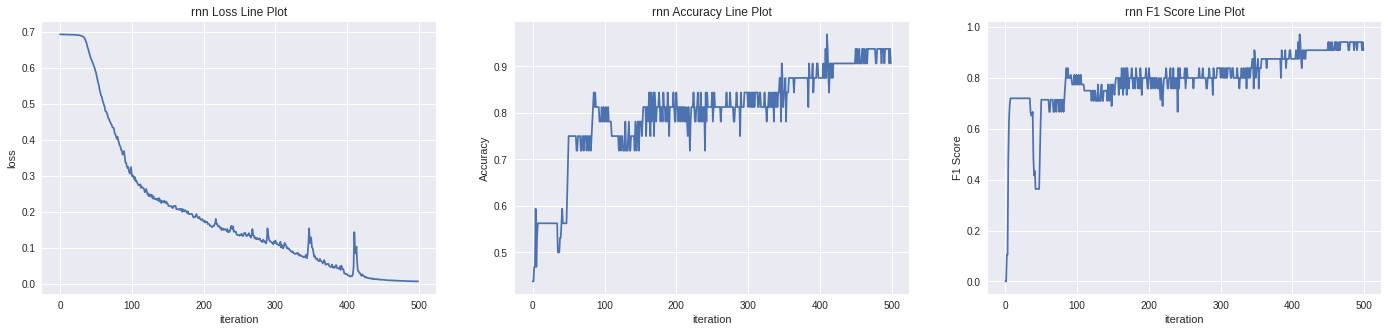


lstm [  1 | 500] train_loss=0.702 valid_accuracy=0.562 valid_f1_score=0.720
lstm [100 | 500] train_loss=0.140 valid_accuracy=0.875 valid_f1_score=0.882
lstm [200 | 500] train_loss=0.106 valid_accuracy=0.906 valid_f1_score=0.914
lstm [300 | 500] train_loss=0.040 valid_accuracy=0.875 valid_f1_score=0.889
lstm [400 | 500] train_loss=0.098 valid_accuracy=0.938 valid_f1_score=0.941
lstm [500 | 500] train_loss=0.056 valid_accuracy=0.906 valid_f1_score=0.909

 lstm Test set evaluation
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.92      0.92      0.92        13

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



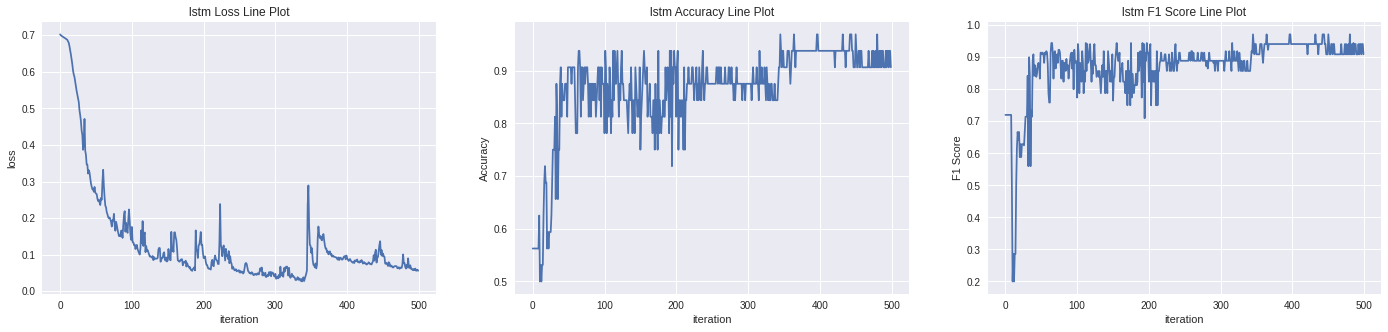


gru [  1 | 500] train_loss=0.695 valid_accuracy=0.562 valid_f1_score=0.720
gru [100 | 500] train_loss=0.312 valid_accuracy=0.781 valid_f1_score=0.774
gru [200 | 500] train_loss=0.122 valid_accuracy=0.875 valid_f1_score=0.875
gru [300 | 500] train_loss=0.077 valid_accuracy=0.906 valid_f1_score=0.909
gru [400 | 500] train_loss=0.035 valid_accuracy=0.906 valid_f1_score=0.909
gru [500 | 500] train_loss=0.027 valid_accuracy=0.938 valid_f1_score=0.941

 gru Test set evaluation
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.93      1.00      0.96        13

    accuracy                           0.97        32
   macro avg       0.96      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



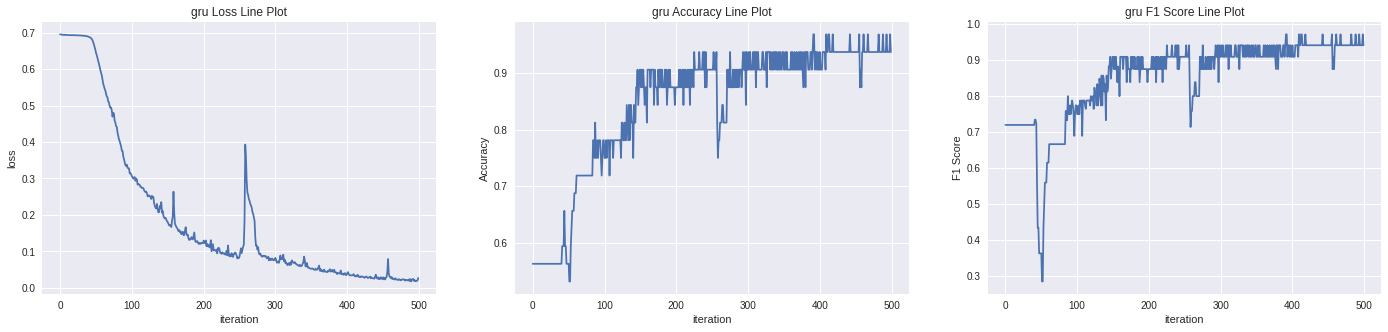

In [40]:
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    loss_lst = []
    for X, y in train_loader:
        X = X.squeeze().reshape(-1, seq_len, input_size).to(device)
        y = y.to(device)
        logits = model(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_lst.append(loss.item())
    
    return loss_lst
    

def valid_step(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    for X, y in test_loader:
        X = X.squeeze().reshape(-1, seq_len, input_size).to(device)
        logits = model(X)
        predictions += logits.argmax(1).tolist()
        true_labels += y.tolist()
    
    return true_labels, predictions

def runner(model_name, num_epochs, learning_rate):
    model = RNNClassifier(model_name, input_size, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    metrics_list = []
    for epoch in range(num_epochs):
        loss_lst = train_step(model, train_loader, criterion, optimizer, device)
        y_true, y_pred = valid_step(model, valid_loader, device)
        train_loss = np.mean(loss_lst)
        valid_accuracy = metrics.accuracy_score(y_true, y_pred)
        valid_f1_score = metrics.f1_score(y_true, y_pred)
        metrics_list.append([train_loss, valid_accuracy, valid_f1_score])
        if epoch % 100 == 99 or epoch == num_epochs - 1 or epoch == 0:
            print(f'{model_name} [{epoch+1:3d} | {num_epochs}] train_loss={train_loss:.3f} valid_accuracy={valid_accuracy:.3f} valid_f1_score={valid_f1_score:.3f}')
    
    # test set evaluation
    y_true, y_pred = valid_step(model, test_loader, device)
    print(f'\n {model_name} Test set evaluation')
    print(metrics.classification_report(y_true, y_pred))
    metrics_list = np.array(metrics_list)
    fig, ax = plt.subplots(1,3, figsize=(24, 5))
    ax[0].plot(metrics_list[:, 0])
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('loss')
    ax[0].set_title(f'{model_name} Loss Line Plot')

    metrics_list = np.array(metrics_list)
    ax[1].plot(metrics_list[:, 1])
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title(f'{model_name} Accuracy Line Plot')

    metrics_list = np.array(metrics_list)
    ax[2].plot(metrics_list[:, 2])
    ax[2].set_xlabel('iteration')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_title(f'{model_name} F1 Score Line Plot')
    plt.show()

num_epochs = 500
model_names = ('rnn', 'lstm', 'gru')
learning_rates = (1e-4, 3e-4, 1e-4)
for model_name, learning_rate in zip(model_names, learning_rates):
    runner(model_name, num_epochs, learning_rate)
    print()

#### RNN, LSTM and GRU Comparison
As shown above, RNN has reached 91% accuracy on the test set, LSTM has reached 94%, and GRU has reached 97%. By comparing these accuracies, we can conclude that for this problem, GRU is the best model for this problem, followed by LSTM and RNN. First, LSTM and GRU are better than RNN; although they are based on RNN, they are modified not to take each time point with the same importance, giving the model more flexibility and thus performing better. In addition, GRU is better than LSTM because there are only a little more than 300 data points, and the padding sequence is not masked, and GRU performs better on this kind of data.

### Part 3 (10 points)

Can you use the traditional feed-forward network to solve the same problem. Why or why not? (Hint: Can time series data be converted to usual features that can be used as input to a feed-forward network?)

Yes, the traditional feed-forward network can solve the same problem, and the performance is about the same as using RNN but not as good as LSTM and GRU. The high-level idea is to flatten the time series data so that each feature of each time point will be treated as a feature for the neural networks, and then we could build a model that classifies these features. This approach works for this problem because the sequence is not long enough, and there are not so many features.

In [41]:
# we are going to flatten each and every time series data
X_train[0][:5]

array([[ 0.      , -0.11111 , -0.24444 , -0.23404 ],
       [ 0.      , -0.91111 , -0.24444 , -0.23404 ],
       [ 0.      , -0.11111 , -0.24444 , -0.10638 ],
       [ 0.090909, -0.33333 ,  0.022222,  0.021277],
       [ 0.090909, -0.11111 , -0.2     ,  0.021277]])

In [55]:
# train valid test set split and also flatten every time series data
X_train_ = X_train.reshape(len(X_train), -1)
X_valid_ = X_valid.reshape(len(X_valid), -1)
X_test_ = X_test.reshape(len(X_test), -1)
train_loader_ = get_loader(X_train_, y_train, shuffle=True)
valid_loader_ = get_loader(X_valid_, y_valid)
test_loader_ = get_loader(X_test_, y_test)
sample_batch = next(iter(train_loader_))
sample_X, sample_y = sample_batch
sample_X.shape

torch.Size([32, 224])

In [60]:
# build mlp model
class MLPClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.output = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.output(x)

input_size = X_train_.shape[1]
hidden_size = 128
model_name = 'mlp'
model = MLPClassifier(input_size, hidden_size, num_classes).to(device)
print(model)
model(sample_batch[0].to(device)).shape 

MLPClassifier(
  (output): Sequential(
    (0): BatchNorm1d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=224, out_features=128, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


torch.Size([32, 2])

mlp [  1 | 500] train_loss=0.682 valid_accuracy=0.625 valid_f1_score=0.684
mlp [100 | 500] train_loss=0.112 valid_accuracy=0.906 valid_f1_score=0.909
mlp [200 | 500] train_loss=0.034 valid_accuracy=0.875 valid_f1_score=0.875
mlp [300 | 500] train_loss=0.028 valid_accuracy=0.875 valid_f1_score=0.875
mlp [400 | 500] train_loss=0.012 valid_accuracy=0.875 valid_f1_score=0.875
mlp [500 | 500] train_loss=0.008 valid_accuracy=0.875 valid_f1_score=0.875

 mlp Test set evaluation
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.86      0.92      0.89        13

    accuracy                           0.91        32
   macro avg       0.90      0.91      0.90        32
weighted avg       0.91      0.91      0.91        32



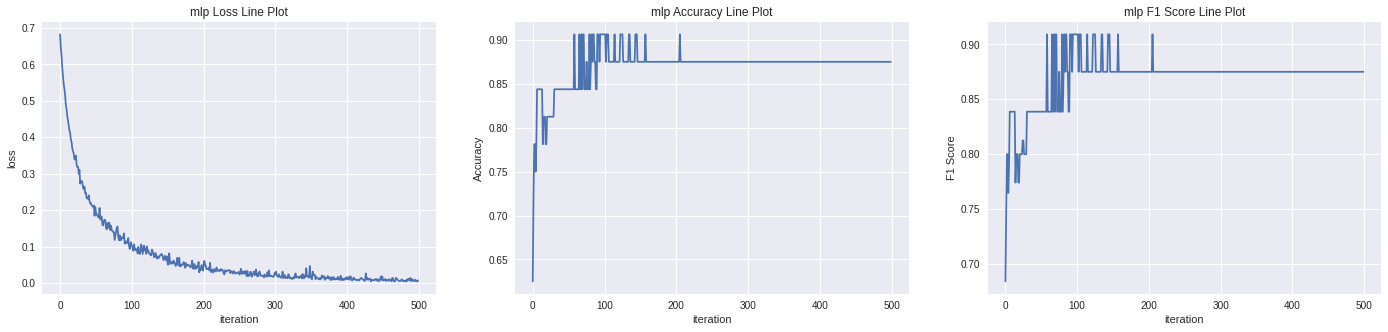

In [61]:
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    loss_lst = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_lst.append(loss.item())
    
    return loss_lst
    

def valid_step(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        predictions += logits.argmax(1).tolist()
        true_labels += y.tolist()
    
    return true_labels, predictions

def runner(num_epochs, learning_rate):
    model = MLPClassifier(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    metrics_list = []
    for epoch in range(num_epochs):
        loss_lst = train_step(model, train_loader_, criterion, optimizer, device)
        y_true, y_pred = valid_step(model, valid_loader_, device)
        train_loss = np.mean(loss_lst)
        valid_accuracy = metrics.accuracy_score(y_true, y_pred)
        valid_f1_score = metrics.f1_score(y_true, y_pred)
        metrics_list.append([train_loss, valid_accuracy, valid_f1_score])
        if epoch % 100 == 99 or epoch == num_epochs - 1 or epoch == 0:
            print(f'{model_name} [{epoch+1:3d} | {num_epochs}] train_loss={train_loss:.3f} valid_accuracy={valid_accuracy:.3f} valid_f1_score={valid_f1_score:.3f}')
    
    # test set evaluation
    y_true, y_pred = valid_step(model, test_loader_, device)
    print(f'\n {model_name} Test set evaluation')
    print(metrics.classification_report(y_true, y_pred))
    metrics_list = np.array(metrics_list)
    fig, ax = plt.subplots(1,3, figsize=(24, 5))
    ax[0].plot(metrics_list[:, 0])
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('loss')
    ax[0].set_title(f'{model_name} Loss Line Plot')

    metrics_list = np.array(metrics_list)
    ax[1].plot(metrics_list[:, 1])
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title(f'{model_name} Accuracy Line Plot')

    metrics_list = np.array(metrics_list)
    ax[2].plot(metrics_list[:, 2])
    ax[2].set_xlabel('iteration')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_title(f'{model_name} F1 Score Line Plot')
    plt.show()

num_epochs = 500
learning_rates = 1e-4
runner(num_epochs, learning_rate)